# IMPORT

In [723]:
import pandas as pd
import numpy as np

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

import xgboost as xgb

In [724]:
df = pd.read_csv('Kangaroo.csv')
df.columns

Index(['Unnamed: 0', 'id', 'url', 'type', 'subtype', 'bedroomCount',
       'bathroomCount', 'province', 'locality', 'postCode', 'habitableSurface',
       'roomCount', 'monthlyCost', 'hasAttic', 'hasBasement',
       'hasDressingRoom', 'diningRoomSurface', 'hasDiningRoom',
       'buildingCondition', 'buildingConstructionYear', 'facedeCount',
       'floorCount', 'streetFacadeWidth', 'hasLift', 'floodZoneType',
       'heatingType', 'hasHeatPump', 'hasPhotovoltaicPanels',
       'hasThermicPanels', 'kitchenSurface', 'kitchenType', 'landSurface',
       'hasLivingRoom', 'livingRoomSurface', 'hasBalcony', 'hasGarden',
       'gardenSurface', 'gardenOrientation', 'parkingCountIndoor',
       'parkingCountOutdoor', 'hasAirConditioning', 'hasArmoredDoor',
       'hasVisiophone', 'hasOffice', 'toiletCount', 'hasSwimmingPool',
       'hasFireplace', 'hasTerrace', 'terraceSurface', 'terraceOrientation',
       'accessibleDisabledPeople', 'epcScore', 'price'],
      dtype='object')

# CLEANING FUNCTION

In [725]:
def cleaning_dataframe(df, df_giraffe = False, is_training = True):
    """
    This function is cleaning the dataframe. The steps are:
    #### Mapping of EPC score (A -> G) into the mean of EPC classification (kWh/m2.year) by region (Wallonia / Flanders / Brussels) & remove unwanted EPC
        df[epcScore] (object)  -> df[epc_enum] (float64)

    #### Removing ahberant values
        df['variable'] >= value (float64 / int64) -> np.nan
    
    #### Fill NaN in booleans columns and mapping true/false in boolean columns
        df['variable_bool'] (NaN) -> df['variable_bool'] = 'False' (object)
        df['variable_bool'] (object) -> df['variable_bool'] (int64)

    #### Summation of the parking counts
        df[ParkingCountIndoor] (float64) + df[ParkingCountOutdoor] (float64) -> df[ParkingCount] (float64) 
    
    #### Label-encoding for categories 
        df[subtype] = subtype (object) -> df[subtype_group] = group of subtypes (int64)
        df[province] (object) -> df[province_mapping] (int64)
        
        df[type] = type (object) -> df[isHouse] (float64)
        df[buildingCondition] (object) -> df[buildingCondition_mapping] (float64) 
        df[floodZoneType] (object) -> df[floodZoneType_mapping] (float64) 
        df[heatingType] (object) -> df[heatingType_mapping] (float64) 
        df[kitchenType] (object) -> df[kitchenType_mapping] (float64)
        
        df[facedeCount] (float64) -> df[facadeCount_mapping] (category)
        df[buildingConstructionYear] = years (float64) -> df[buildingConstructionYear_mapping] (category)

    #### Missing values for gardenSurface or terraceSurface
        0 if hasGarden or hasTerrace is 0

    #### Drop rows where there is no bathroomCount or bedroomCount 

    #### Merge 4 columns from data.csv (df_giraffe) where df_giraffe['propertyId'] == df['id']
        df_giraffe['latitude', 'longitude'] (float64)
        df_giraffe['primaryEnergyConsumptionPerSqm', 'cadastralIncome'] (int64)

    #### Filter the rows with a price margin (in a range of 50 000€ to 1 000 000€)

    #### Remove columns we don't use

    """
    
    #EPC SCORE
    epc_unwanted = ['C_A', 'F_C', 'G_C', 'D_C', 'F_D', 'E_C', 'G_E', 'E_D', 'C_B', 'X', 'G_F']
    df = df[~df['epcScore'].isin(epc_unwanted)]

    wallonia_provinces = ['Liège', 'Walloon Brabant', 'Namur', 'Hainaut', 'Luxembourg']
    flanders_provinces = ['Antwerp', 'Flemish Brabant', 'East Flanders', 'West Flanders', 'Limburg']

    wallonia_epc_map = {
        'A++' : 0,
        'A+' : 30,
        'A' : 65,
        'B' : 125,
        'C' : 200,
        'D' : 300,
        'E' : 375,
        'F' : 450,
        'G' : 510
    }

    flanders_epc_map = {
        'A++' : 0,
        'A+' : 0,
        'A' : 50,
        'B' : 150,
        'C' : 250,
        'D' : 350,
        'E' : 450,
        'F' : 500,
        'G' : 510,
    }

    brussels_epc_map = { 
        'A++' : 0,
        'A+' : 0,
        'A' : 45,
        'B' : 75,
        'C' : 125, 
        'D' : 175,
        'E' : 250,
        'F' : 300,
        'G' : 350,
    }

    df.loc[df['province'].isin(wallonia_provinces), 'epc_enum'] = df['epcScore'].map(wallonia_epc_map).apply(pd.to_numeric)
    df.loc[df['province'].isin(flanders_provinces), 'epc_enum'] = df['epcScore'].map(flanders_epc_map).apply(pd.to_numeric)
    df.loc[df['province'] == 'Brussels', 'epc_enum'] = df['epcScore'].map(brussels_epc_map).apply(pd.to_numeric)

    # REMOVE ERROS / TOO BIG VALUES
    df_without_outliers = df
    df_without_outliers.loc[df_without_outliers['bedroomCount'] >= 100, 'bedroomCount'] = np.nan
    df_without_outliers.loc[df_without_outliers['bathroomCount'] >= 100, 'bathroomCount'] = np.nan
    df_without_outliers.loc[df_without_outliers['toiletCount'] >= 25, 'toiletCount'] = np.nan
    df_without_outliers.loc[df_without_outliers['habitableSurface'] >= 600, 'habitableSurface'] = np.nan
    df_without_outliers.loc[df_without_outliers['landSurface'] >= 1000, 'landSurface'] = np.nan
    df_without_outliers.loc[df_without_outliers['gardenSurface'] >= 500, 'gardenSurface'] = np.nan
    df_without_outliers.loc[df_without_outliers['terraceSurface'] >= 250, 'terraceSurface'] = np.nan
    df_without_outliers.loc[df_without_outliers['parkingCountIndoor'] >= 10, 'parkingCountIndoor'] = 1
    df_without_outliers.loc[df_without_outliers['parkingCountOutdoor'] >= 10, 'parkingCountOutdoor'] = 1
    
    # BOOLEANS COLUMNS (FILL NaN + MAPPING)
    booleans_columns = ['hasAttic', 'hasBasement', 'hasDressingRoom', 'hasDiningRoom', 'hasLift', 'hasHeatPump', 'hasPhotovoltaicPanels', 'hasThermicPanels', 'hasLivingRoom', 'hasGarden', 'hasAirConditioning', 'hasArmoredDoor', 'hasVisiophone', 'hasOffice', 'hasSwimmingPool', 'hasFireplace', 'hasTerrace']
    df_without_outliers.loc[:, booleans_columns] = df_without_outliers[booleans_columns].fillna('False')

    boolean_to_num = {'True' : 1, 
        'true' : 1, 
        'False' : 0, 
        'false' : 0,
        False : 0,
        True: 1}

    for col in booleans_columns:
        df_without_outliers[col] = df_without_outliers[col].replace('nan', 'false') #parfois je pense qu'il est écrit nan et c'est pas NaN
        df_without_outliers[col] = df_without_outliers[col].map(boolean_to_num)

    
    # CREATE A PARKING COLUMN (INDOOR + OUTDOOR) 
    df_without_outliers['parkingCount'] = df_without_outliers[['parkingCountIndoor', 'parkingCountOutdoor']].sum(axis=1, min_count=1)
    df_without_outliers[['parkingCount', 'parkingCountIndoor', 'parkingCountOutdoor']]
    
    # LABEL-ENCODING FOR CATEGORIES
    ## subgroup
    subtype_to_group = {
    "APARTMENT": 1,
    "FLAT_STUDIO": 1,
    "DUPLEX": 1,
    "TRIPLEX": 1,
    "PENTHOUSE": 1,
    "LOFT": 1,
    "SERVICE_FLAT": 1,
    "GROUND_FLOOR": 1,
    "KOT": 1,
    "MIXED_USE_BUILDING": 1,

    "HOUSE": 2,
    "TOWN_HOUSE": 2,
    "VILLA": 2,
    "CHALET": 2,
    "BUNGALOW": 2,
    "COUNTRY_COTTAGE": 2,

    "MANOR_HOUSE": 3,
    "MANSION": 3,
    "EXCEPTIONAL_PROPERTY": 3,
    "CASTLE": 3,
    "FARMHOUSE": 3,

    "APARTMENT_BLOCK": 4,
    "APARTMENT_GROUP" : 4,
    "HOUSE_GROUP": 4,

    "OTHER_PROPERTY": 5,
    "PAVILION": 5
    }

    df_without_outliers.loc[:, 'subtype_group'] = df_without_outliers['subtype'].map(subtype_to_group).apply(pd.to_numeric)

    ## building construction year
    years_bins = [1850, 1875, 1900, 1925, 1950, 1975, 2000, 2025, 2050]
    years_labels = [1, 2, 3, 4, 5, 6, 7, 8]
    df_without_outliers.loc[:, 'buildingConstructionYear_mapping'] = pd.cut(
    df_without_outliers['buildingConstructionYear'], 
    bins= years_bins,
    labels= years_labels)

    ## type
    df_without_outliers.loc[:, 'isHouse'] = df_without_outliers['type'].map({ 
        "APARTMENT" : 0,
        "HOUSE" : 1
    }).apply(pd.to_numeric)

    ## provinces
    df_without_outliers.province.unique()
    province_mapping = { 
        'Brussels' : 1,
        'Luxembourg' : 2,
        'Antwerp' : 3,
        'Flemish Brabant' : 4,
        'East Flanders' : 5,
        'West Flanders' : 6,
        'Liège' : 7,
        'Walloon Brabant' : 8,
        'Limburg' : 9,
        'Namur' : 10,
        'Hainaut' : 11
    }

    df_without_outliers.loc[:, 'province_mapping'] = df_without_outliers['province'].map(province_mapping).apply(pd.to_numeric)

    ## building condition
    condition_mapping = { 
            'GOOD' : 5,
            'TO_BE_DONE_UP' : 4,
            'AS_NEW' : 3,
            'JUST_RENOVATED' : 2,
            'TO_RENOVATE' : 1,
            'TO_RESTORE' : 0
        }

    df_without_outliers['buildingCondition_mapping'] = df_without_outliers['buildingCondition'].map(condition_mapping).apply(pd.to_numeric)

    ## flood zone type
    floodZoneType_mapping = {
            "NON_FLOOD_ZONE": 1,
            "POSSIBLE_N_CIRCUMSCRIBED_WATERSIDE_ZONE": 2,
            "CIRCUMSCRIBED_WATERSIDE_ZONE": 3,
            "POSSIBLE_N_CIRCUMSCRIBED_FLOOD_ZONE": 4,
            "POSSIBLE_FLOOD_ZONE": 5,
            "CIRCUMSCRIBED_FLOOD_ZONE": 6,
            "RECOGNIZED_FLOOD_ZONE": 7,
            "RECOGNIZED_N_CIRCUMSCRIBED_WATERSIDE_FLOOD_ZONE": 8,
            "RECOGNIZED_N_CIRCUMSCRIBED_FLOOD_ZONE": 9
            }

    df_without_outliers['floodZoneType_mapping'] = df_without_outliers['floodZoneType'].map(floodZoneType_mapping).apply(pd.to_numeric)

    ## heating type
    heatingType_mapping = { 
        'GAS' : 1, 
        'FUELOIL' : 2, 
        'ELECTRIC' : 3, 
        'PELLET' : 4, 
        'WOOD' : 4, 
        'SOLAR' : 4, 
        'CARBON' : 4
    }

    df_without_outliers.loc[:, 'heatingType_mapping'] = df_without_outliers['heatingType'].map(heatingType_mapping).apply(pd.to_numeric)

    ## kitchen type
    kitchenType_mapping = {
        "NOT_INSTALLED": 0,
        "USA_UNINSTALLED": 0,

        "USA_SEMI_EQUIPPED": 1,
        "SEMI_EQUIPPED": 1,

        "USA_INSTALLED": 2,
        "INSTALLED": 2,

        "USA_HYPER_EQUIPPED": 3,
        "HYPER_EQUIPPED": 3,
        }

    df_without_outliers.loc[:, 'kitchenType_mapping'] = df.kitchenType.map(kitchenType_mapping).apply(pd.to_numeric)

    ## facade count
    facedeCount_bins = [0, 1, 2, 3, 4, float('inf')]
    facedeCount_labels = [1, 2, 3, 4, 5]

    df_without_outliers.loc[:, 'facadecount_mapping'] = pd.cut( 
        df_without_outliers['facedeCount'],
        bins = facedeCount_bins,
        labels = facedeCount_labels,
        include_lowest= True
    ).apply(pd.to_numeric)

    # MISSING VALUE FOR ...SURFACE
    df_without_outliers.loc[df_without_outliers['hasGarden']  == 0, 'gardenSurface'] = 0
    df_without_outliers.loc[df_without_outliers['hasTerrace']  == 0, 'terraceSurface'] = 0

    # IF NO BATHROOM OR BEDROOM COUNT: DROP
    if is_training: 
        df_new = df_without_outliers.dropna(subset=['bedroomCount', 'bathroomCount'])

    else:
        df_new = df_without_outliers
    
    # IMPORT FROM AN OTHER DATASET
    if is_training : 
        df_giraffe = pd.read_csv('data.csv')
        df_with_giraffe = df_new.merge(
        df_giraffe[['propertyId', 'latitude', 'longitude', 'primaryEnergyConsumptionPerSqm', 'cadastralIncome']],  
        how='inner',
        left_on='id',
        right_on='propertyId'
        )

    else: 
        df_with_giraffe = df_new
        giraffe_cols = [
        "latitude",
        "longitude",
        "primaryEnergyConsumptionPerSqm",
        "cadastralIncome"
        ]
        for col in giraffe_cols:
            if col not in df.columns:
                df[col] = 0
    # PRICE MARGIN
    if is_training: 
        df_price_margin = df_with_giraffe[(df_with_giraffe['price'] >= 50000) & (df_with_giraffe['price'] <= 1000000)]
    
    else: 
        df_price_margin = df_with_giraffe

    # REMOVE ROWS
    df_dropped = df_price_margin.drop(columns=['Unnamed: 0', 'url', 'type', 'subtype', 'province', 'monthlyCost', 'diningRoomSurface', 'buildingCondition', 'buildingConstructionYear', 'facedeCount', 'floorCount', 'streetFacadeWidth', 'floodZoneType', 'kitchenType', 'hasBalcony', 'gardenOrientation', 'terraceOrientation', 'accessibleDisabledPeople', 'epcScore', 'kitchenSurface', 'livingRoomSurface', 'roomCount', 'parkingCountIndoor', 'parkingCountOutdoor', 'locality', 'postCode', 'propertyId', 'epcScore', 'hasTerrace', 'hasGarden', 'heatingType'], errors='ignore')

    return df_dropped

In [726]:
def stats(X_train):
    """ 
    Dictionnaire de stats (stats_from_X_train) stocke toutes les informations nécessaires à l’imputation des valeurs manquantes.
    
    # Fill_with_mode:
    Pour chacune de ces colonnes, elle calcule la valeur la plus fréquente (mode) dans X_train.
    
    # Fill_with_median : 
    Pour les colonnes quantitatives comme gardenSurface et terraceSurface, la fonction calcule la médiane sur X_train.

    
    # Imputation par régression pour les features importantes: 
    - toiletCount imputée via les variables bedroomCount, bathroomCount, habitableSurface
    - habitableSurface imputée via les variables bathroomCount, bedroomCount, parkingCount, isHouse
    - landSurface imputée via les variables habitableSurface, gardenSurface, parkingCount

    Chaque imputer est fit exclusivement sur X_train.
    
    #La fonction retourne stats_from_X_train, contenant :
    - Les modes calculées
    - Les médianes
    - Les trois modèles d’imputation régressive déjà entraînés
        
    """
    stats_from_X_train = {}
    stats_from_X_train['imputers'] = {}

    # fill with mode 
    fill_with_mode = [
        'heatingType_mapping', 'facadecount_mapping', 'floodZoneType_mapping',
        'buildingCondition_mapping', 'buildingConstructionYear_mapping', 'epc_enum', 'kitchenType_mapping'
    ]
    
    stats_from_X_train['mode'] = {
        col: X_train[col].mode()[0] for col in fill_with_mode
        }

    # fill with median 
    fill_with_median = ['gardenSurface', 'terraceSurface']
    stats_from_X_train['median'] = {
        col: X_train[col].median() for col in fill_with_median
        }

    # regression imputation 
    stats_from_X_train['imputers']['toiletCount'] = IterativeImputer(max_iter=10, random_state=0, initial_strategy='median').fit(
        X_train[['bedroomCount', 'bathroomCount', 'toiletCount', 'habitableSurface']]
    )
    stats_from_X_train['imputers']['habitableSurface'] = IterativeImputer(max_iter=10, random_state=0, initial_strategy='median').fit(
        X_train[['bathroomCount', 'bedroomCount', 'parkingCount', 'isHouse', 'habitableSurface']]
    )
    stats_from_X_train['imputers']['landSurface'] = IterativeImputer(max_iter=10, random_state=0, initial_strategy='median').fit(
        X_train[['habitableSurface', 'gardenSurface', 'parkingCount', 'landSurface']]
    )

    return stats_from_X_train


In [727]:
def transform_cleaning_traintestsplit(df, stats, is_training=True):
    """
    This function is for imputation of missing values.
    It has to be made on the dataframe splitted into x_test & x_train to don't have any data leakage.

    #### Regression imputation for important features 
    NaN in toiletCount, habitableSurface, parkingCount, landSurface -> mode (float64)

    #### Imputation with the mode for missing values in label variables 
    Note: facadecount_mapping & buildingConstructionYear_mapping (categrory) -> (int64)

    #### Imputation with the median for missing values in continuous variables

    #### Remove rows where there is any missing 
    """

    df = df.copy()

    # REGRESSION IMPUTATION
    for feature, features_related in [('toiletCount', ['bedroomCount', 'bathroomCount', 'toiletCount', 'habitableSurface']),
                      ('habitableSurface', ['bathroomCount', 'bedroomCount', 'parkingCount', 'isHouse', 'habitableSurface']),
                      ('landSurface', ['habitableSurface', 'gardenSurface', 'parkingCount', 'landSurface'])]:
        
        if all(col in df.columns for col in features_related):
            df_imputed = stats['imputers'][feature].transform(df[features_related])
            df_imputed = pd.DataFrame(df_imputed, columns=features_related).round()
            for col in features_related:
                df[col] = df_imputed[col].values

    # MODE IMPUTATION 
    for col, mode_val in stats['mode'].items():
        if col in df.columns:
            df[col] = df[col].fillna(mode_val)

    # MEDIAN IMPUTATION 
    for col, median_val in stats['median'].items():
        if col in df.columns:
            df[col] = df[col].fillna(median_val)
   
    # CATEGORY TO INT
    for col in ['facadecount_mapping', 'buildingConstructionYear_mapping']:
        if col in df.columns:
            df[col] = df[col].astype(int, errors='ignore')

    # REMOVE ROWS WHERE NAN
    if is_training :
        df_final = df[~df.isna().any(axis=1)].copy()

    else: 
        df_final = df

    return df_final

# TRAIN TEST SPLIT

In [728]:
df_final = cleaning_dataframe(df, df_giraffe=df_giraffe)

y = df_final['price']
X = df_final.drop(['price', 'id'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

C:\Users\elsar\AppData\Local\Temp\ipykernel_33504\1640745165.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['province'].isin(wallonia_provinces), 'epc_enum'] = df['epcScore'].map(wallonia_epc_map).apply(pd.to_numeric)
C:\Users\elsar\AppData\Local\Temp\ipykernel_33504\1640745165.py:116: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_without_outliers[col] = df_without_outliers[col].replace('nan', 'false') #parfois je pense qu'il est écrit nan et c'est pas NaN
C:\Users\elsar\AppData\Local\Tem

In [729]:
# Cleaning X_train with the imputations 
stats_from_X_train = stats(X_train)
X_train_clean = transform_cleaning_traintestsplit(X_train, stats_from_X_train)

# Cleaning X_test with the imputations from X_train
X_test_clean  = transform_cleaning_traintestsplit(X_test, stats_from_X_train)

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_clean)
X_test_scaled = scaler.transform(X_test_clean)

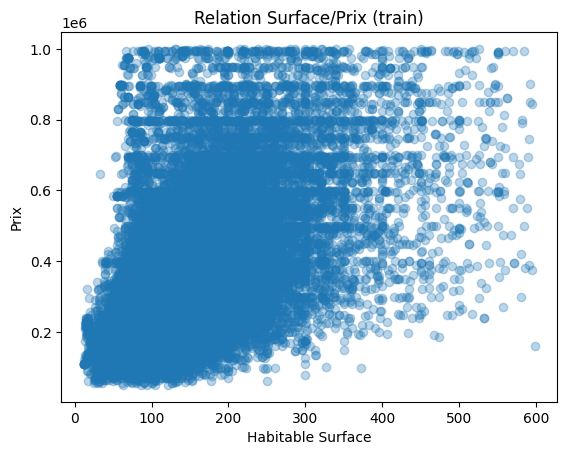

In [730]:
import matplotlib.pyplot as plt
plt.scatter(X_train['habitableSurface'], y_train, alpha=0.3)
plt.xlabel("Habitable Surface")
plt.ylabel("Prix")
plt.title("Relation Surface/Prix (train)")
plt.show()


# XGBOOST MODEL

In [731]:
xgb_model = xgb.XGBRegressor(n_estimators=3000, random_state=43, learning_rate=0.05, subsample= 0.8)

In [732]:
xgb_model.fit(X_train_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=3000,
             n_jobs=None, num_parallel_tree=None, ...)

In [733]:
y_pred = xgb_model.predict(X_test_scaled)

In [734]:
r2 = r2_score(y_test, y_pred)
print("R2 Score:", r2)

R2 Score: 0.8245819285983635


In [735]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error (RMSE):", rmse, "€")

rae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (RAE):", rae, "€")

mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

Root Mean Squared Error (RMSE): 77420.26372808329 €
Mean Absolute Error (RAE): 51736.03346818656 €
Mean Squared Error: 5993897235.725968


In [736]:
import joblib 

# Save the model
joblib.dump(xgb_model, 'my_xgb_model_immo.pkl') 

['my_xgb_model_immo.pkl']

## DEPLOYMENT PREPARATION

In [ ]:
df_final_order = ['id', 'bedroomCount', 'bathroomCount', 'habitableSurface', 'hasAttic',
       'hasBasement', 'hasDressingRoom', 'hasDiningRoom', 'hasLift',
       'hasHeatPump', 'hasPhotovoltaicPanels', 'hasThermicPanels',
       'landSurface', 'hasLivingRoom', 'gardenSurface', 'hasAirConditioning',
       'hasArmoredDoor', 'hasVisiophone', 'hasOffice', 'toiletCount',
       'hasSwimmingPool', 'hasFireplace', 'terraceSurface', 'price',
       'epc_enum', 'parkingCount', 'subtype_group',
       'buildingConstructionYear_mapping', 'isHouse', 'province_mapping',
       'buildingCondition_mapping', 'floodZoneType_mapping',
       'heatingType_mapping', 'kitchenType_mapping', 'facadecount_mapping',
       'latitude', 'longitude', 'primaryEnergyConsumptionPerSqm',
       'cadastralIncome'],

house_or_appart = { 
    'Unnamed: 0' : np.nan,
    'id' : np.nan,
    'url' : np.nan,
    'type' : 'HOUSE',
    'subtype' : 'HOUSE',
    'bedroomCount' : 2,
    'bathroomCount' : 2, 
    'province' : 'Brussels', 
    'locality' : 'Ixelles',
    'postCode' : 1050,
    'habitableSurface' : 350, 
    'roomCount' : np.nan,
    'monthlyCost' : np.nan,
    'hasAttic' : 'False',
    'hasBasement' : 'False',
    'hasDressingRoom' : np.nan,
    'diningRoomSurface' : np.nan,
    'hasDiningRoom' : 'False',
    'buildingCondition' : 'AS_NEW',
    'buildingConstructionYear' : 1899,
    'facedeCount' : 10,
    'floorCount' : np.nan,
    'streetFacadeWidth' : np.nan,
    'hasLift' : 'False',
    'floodZoneType' : np.nan, 
    'heatingType' : 'GAS',
    'hasHeatPump' : 'False',
    'hasPhotovoltaicPanels' : 'True',
    'hasThermicPanels' : np.nan,
    'kitchenSurface' : np.nan,
    'kitchenType' : 'INSTALLED',
    'landSurface' : 100,
    'hasLivingRoom' : 'False',
    'livingRoomSurface' : np.nan,
    'hasBalcony' : 'False',
    'hasGarden' : 'False',
    'gardenSurface' : 0,
    'gardenOrientation' : np.nan,
    'parkingCountIndoor' : 0,
    'parkingCountOutdoor' : np.nan,
    'hasAirConditioning' : 'False',
    'hasArmoredDoor' : np.nan,
    'hasVisiophone' : np.nan,
    'hasOffice' : 'True',
    'toiletCount' : 3,
    'hasSwimmingPool' : 'False',
    'hasFireplace' : np.nan,
    'hasTerrace' : 'False',
    'terraceSurface' : np.nan,
    'terraceOrientation' : np.nan,
    'accessibleDisabledPeople' : np.nan,
    'epcScore' : 'C',
    'price' : np.nan

}

# 1. Création du DataFrame à partir du dict 'propre' (raw features)
df_new = pd.DataFrame([house_or_appart])

# 2. Nettoyage & feature engineering
df_new_clean = cleaning_dataframe(df_new, is_training=False)

# 3. Réalignement des colonnes (ID & price ne sont pas nécessaires/présents à ce stade)
cols_for_predict = df_final_order[0] 
cols_for_predict = [col for col in cols_for_predict if col not in ["id", "price"]]

# 4. Imputations
df_new_cleaned = transform_cleaning_traintestsplit(df_new_clean, stats_from_X_train, is_training=False)

# 5. Scaling (en gardant le fit de tes données d’entraînement)
columns_for_model = scaler.feature_names_in_.tolist()
df_new_cleaned = df_new_cleaned[columns_for_model]

df_new_scaled = scaler.transform(df_new_cleaned)

# 6. Prédiction
predicted_price = xgb_model.predict(df_new_scaled)

print(f"Le prix prédit est {predicted_price[0]:,.0f} €".replace(',', ' '))


Le prix prédit est 898 782 €


C:\Users\elsar\AppData\Local\Temp\ipykernel_33504\1640745165.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['False']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_without_outliers.loc[:, booleans_columns] = df_without_outliers[booleans_columns].fillna('False')
C:\Users\elsar\AppData\Local\Temp\ipykernel_33504\1640745165.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['False']' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_without_outliers.loc[:, booleans_columns] = df_without_outliers[booleans_columns].fillna('False')
C:\Users\elsar\AppData\Local\Temp\ipykernel_33504\1640745165.py:106: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['False']' has dtype incompatible

In [738]:
"""X_small = X_train_clean.copy()
X_large = X_train_clean.copy()

X_small['col'] = X_small['col'].min()
X_large['col'] = X_large['col'].max()

X_small_scaled = scaler.transform(X_small)
X_large_scaled = scaler.transform(X_large)

pred_small = xgb_model.predict(X_small_scaled[:1])
pred_large = xgb_model.predict(X_large_scaled[:1])

print("Prix prédit (petite surface):", pred_small)
print("Prix prédit (grande surface):", pred_large)
"""

'X_small = X_train_clean.copy()\nX_large = X_train_clean.copy()\n\nX_small[\'col\'] = X_small[\'col\'].min()\nX_large[\'col\'] = X_large[\'col\'].max()\n\nX_small_scaled = scaler.transform(X_small)\nX_large_scaled = scaler.transform(X_large)\n\npred_small = xgb_model.predict(X_small_scaled[:1])\npred_large = xgb_model.predict(X_large_scaled[:1])\n\nprint("Prix prédit (petite surface):", pred_small)\nprint("Prix prédit (grande surface):", pred_large)\n'

In [739]:
'''importances = xgb_model.feature_importances_
for col, imp in zip(X_train.columns, importances):
    print(f"{col}: {imp:.4f}")'''


'importances = xgb_model.feature_importances_\nfor col, imp in zip(X_train.columns, importances):\n    print(f"{col}: {imp:.4f}")'